In [1]:
import sys

# 親ディレクトリのパスを直接追加
sys.path.append('/Users/ham/Desktop/LSHiforest')

import numpy as np
import pandas as pd
from JLSHiForest import JLSHiForest
from sklearn.metrics import accuracy_score

In [2]:
# === サンプル数指定 ===
train_samples = 50000   # 学習用正常データ数
test_samples = 20000   # テスト用（正常+異常）データ数

# === NSL-KDD列名（41特徴量 + ラベル） ===
column_names = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login',
    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
    'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
    'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
    'dst_host_srv_rerror_rate','label', 'difficulty'
]

# === データ読み込み ===
df_full = pd.read_csv("KDDTrain+.txt", names=column_names)

# === 文字列特徴量と数値特徴量分離 ===
categorical_columns = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
numerical_columns = [col for col in df_full.columns if col not in categorical_columns + ['label', 'difficulty']]

# === ラベル変換（normal→0, 攻撃→1） ===
df_full['label'] = df_full['label'].apply(lambda x: 0 if x == 'normal' else 1)

# === 正常データと異常データを分離 ===
normal_data = df_full[df_full['label'] == 0]
anomaly_data = df_full[df_full['label'] == 1]

# 正常・異常データをシャッフル
normal_data_shuffled = normal_data.sample(frac=1, random_state=42).reset_index(drop=True)
anomaly_data_shuffled = anomaly_data.sample(frac=1, random_state=42).reset_index(drop=True)

# 学習データとテストデータを分離
normal_train = normal_data_shuffled.iloc[:train_samples]
normal_test = normal_data_shuffled.iloc[train_samples:]

# テストデータ = 正常の残り + 全異常データから構成し、シャッフル
test_data = pd.concat([normal_test, anomaly_data_shuffled]).sample(frac=1, random_state=42).reset_index(drop=True)

# === 数値特徴量のビニング関数 ===
def bin_numerical_features(df, numerical_columns, n_bins=10):
    df_binned = df.copy()
    for col in numerical_columns:
        unique_vals = df[col].nunique()
        if unique_vals > n_bins:
            df_binned[col] = pd.cut(df[col], bins=n_bins, labels=False)
        else:
            df_binned[col] = df[col]
    return df_binned

# === ビニング適用 ===
train_binned = bin_numerical_features(normal_train, numerical_columns)
test_binned = bin_numerical_features(test_data, numerical_columns)

# === 特徴量セット作成 ===
features_to_use = categorical_columns + numerical_columns

X_train = train_binned[features_to_use]
y_train = normal_train['label']

X_test = test_binned[features_to_use].iloc[:test_samples]
y_test = test_binned['label'].iloc[:test_samples]

# === 結果表示 ===
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Train label distribution: {y_train.value_counts().to_dict()}")
print(f"Test label distribution: {y_test.value_counts().to_dict()}")


X_train: (50000, 41), y_train: (50000,)
X_test: (20000, 41), y_test: (20000,)
Train label distribution: {0: 50000}
Test label distribution: {1: 15455, 0: 4545}


In [3]:
# モデル訓練・評価
model = JLSHiForest(n_trees=100, max_depth=10, num_hashes=1, min_samples=10, random_state=42)
model.fit(X_train)
scores = model.decision_function(X_test)

universe size : 310


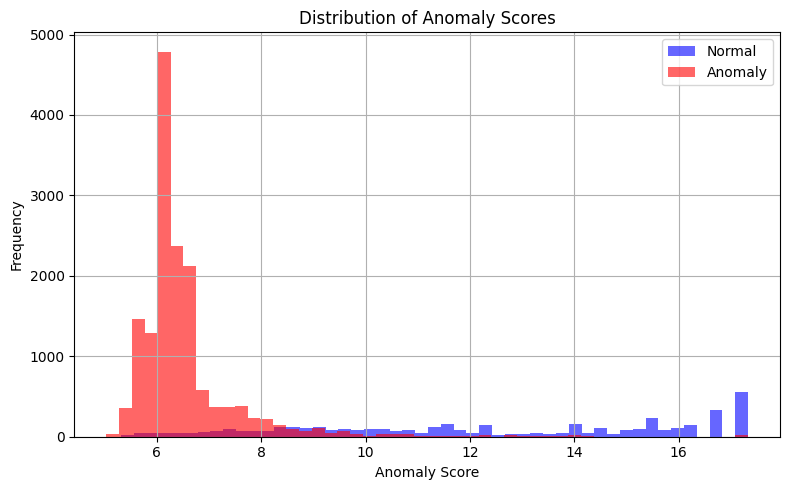

In [4]:
# 異常スコアの分布をプロット
model.plot_score_distribution(scores, y_test)

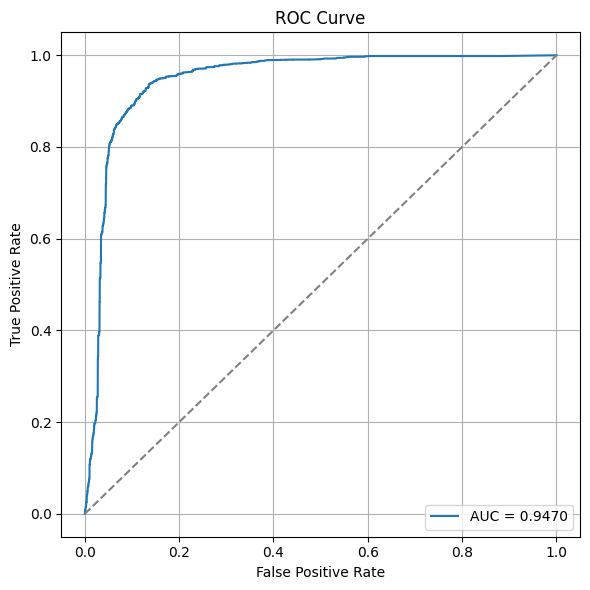

In [5]:
# AUC-ROCを計算
auc = model.plot_roc_curve(scores, y_test)

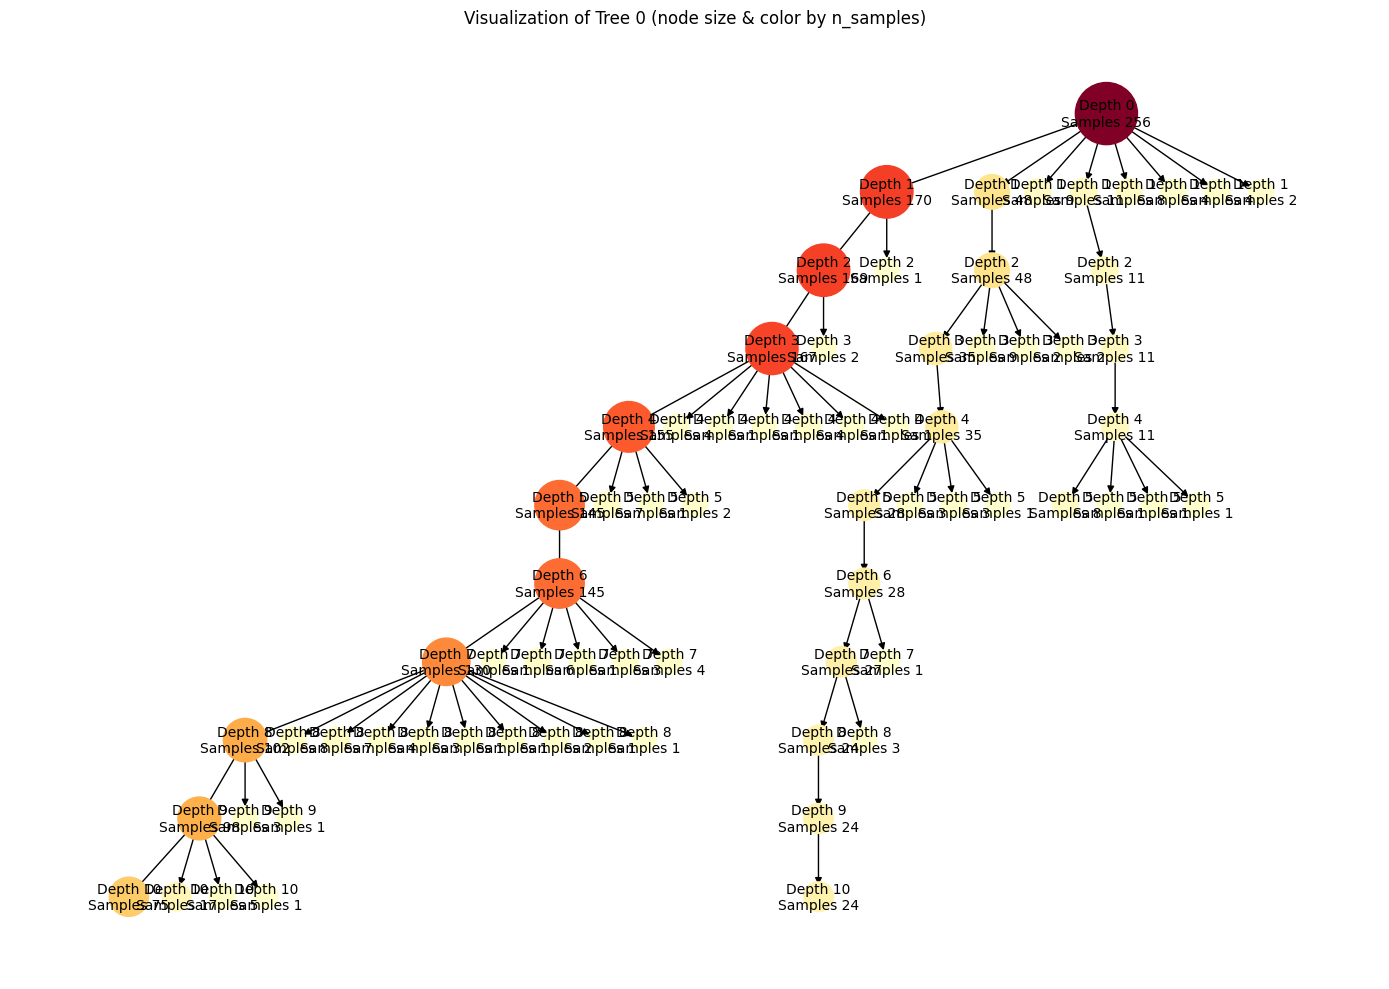

In [6]:
# treeを可視化
model.visualize_tree(tree_index=0)